# Análisis de Resultados

En esta sección se presentan los análisis detallados de los resultados obtenidos en la evaluación de los modelos de generación de consultas SQL. El objetivo es **comparar el desempeño de los distintos modelos** en base a las métricas previamente establecidas y extraer conclusiones sobre su efectividad y posibles áreas de mejora.

## 1. Lectura de datos consolidados
En primer lugar, cargamos en un único DataFrame (`df_final_resultados`) los resultados que obtuvimos para cada modelo, donde cada fila corresponde a una pregunta de prueba y contiene:
- **Consulta**: la consulta de referencia
- **Consulta Generada**: la consulta SQL generada por el modelo
- **Modelo**: tipo de modelo (Deepseek Coder base, Deepseek Coder fine-tuned, OpenAI 4o)
- **Validas**: indica si la consulta es "Query válida" o un mensaje de error
- **Exacta**: `True/False` que indica coincidencia literal (sintáctica) entre la consulta de referencia y la generada
- **Semántica**: `True/False` que indica si las consultas son equivalentes tras normalización SQL (estructura)
- **Jaccard** y **Overlap**: métricas de similitud de resultados tras ejecutar cada consulta en la base de datos.

In [2]:
# Ejemplo de carga (asumiendo que df_final_resultados ya fue creado en la sección previa):
import pandas as pd

# Nota: Esta carga es un placeholder, en tu flujo ya lo tienes
df_final_resultados = pd.read_csv("results_tests/resultados_test_consolidados.csv")

# Si ya tenemos df_final_resultados en memoria, simplemente lo mostramos:
df_final_resultados.head()

,Unnamed: 0.1,Unnamed: 0,Pregunta,Consulta,Tabla,Valores,Categoría,Consulta Generada,Modelo,Validas,Exacta,Semántica,Jaccard,Overlap
0,0,210,Solicito información de expedientes en Cuenca.,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,{'region': 'Cuenca'},region,SELECT * FROM expedientes WHERE party_nif = 'S...,Deepseek Coder 1.3B base,"[0, ""no existe la columna «party_subentity_cod...",False,False,Query inválida,Query inválida
1,1,211,Muestra los expedientes de Concesión de Servic...,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,"{'tipo': 'Concesión de Servicios', 'entidad': ...",entidad_tipo_estado_cuantia_inferior,SELECT * FROM expedientes WHERE contract_folde...,Deepseek Coder 1.3B base,Query válida,False,False,0.0,0
2,2,212,Solicito información de expedientes en Consejo...,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,{'entidad': 'Consejo de Administración de la S...,entidad_cuantia_superior,SELECT * FROM expedientes WHERE contract_folde...,Deepseek Coder 1.3B base,Query válida,False,False,0.0,0
3,3,213,Muestra los expedientes de Obras en Televisión...,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,"{'tipo': 'Obras', 'entidad': 'Televisión Públi...",entidad_tipo_estado,SELECT * FROM expedientes WHERE contract_folde...,Deepseek Coder 1.3B base,Query válida,False,False,0.0,0
4,4,214,Muestra los expedientes de Gestión de Servicio...,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,"{'tipo': 'Gestión de Servicios Públicos', 'ent...",entidad_tipo_cuantia_inferior,SELECT * FROM expedientes WHERE party_nif = 'S...,Deepseek Coder 1.3B base,Query válida,False,False,0.0,0


## 2. Evaluación de la validez de las consultas SQL
A continuación, se observa qué porcentaje de consultas generadas son sintácticamente correctas y pueden ejecutarse sin errores en la base de datos. 

Para ello, se definió la columna `Validas`, que indica si la consulta fue satisfactoriamente ejecutada en la base de datos PostgreSQL. Si no fue válida, esta columna contendrá un mensaje de error.

A partir de este campo, podemos calcular la tasa de validez de las consultas:


In [5]:
# Convertimos la columna Validas en un booleano: True si es 'Query válida', False en caso contrario
df_final_resultados['Valida_bool'] = df_final_resultados['Validas'].apply(
    lambda x: True if isinstance(x, str) and x == 'Query válida' else False
)

# Luego agrupamos por modelo para ver el % de consultas válidas
validez_consultas = (
    df_final_resultados.groupby("Modelo")['Valida_bool']
    .mean()
    .reset_index()
    .rename(columns={'Valida_bool': 'Tasa de consultas válidas'})
)
validez_consultas

,Modelo,Tasa de consultas válidas
0,Deepseek Coder 1.3B base,0.885714
1,Deepseek Coder 1.3B fine-tuned 1,0.742857
2,Deepseek Coder 1.3B fine-tuned 2,0.314286
3,OpenAI 4o,0.857143


### Análisis de Errores Frecuentes
En caso de que aparezcan errores, se pueden extraer y agrupar para identificar patrones, por ejemplo:
- Columnas inexistentes
- Tablas fuera del esquema
- Errores de sintaxis

Dicha identificación sirve para **mejorar el conjunto de entrenamiento** y/o el **prompt** entregado al modelo.

## 3. Comparación de modelos por Exactitud Sintáctica
En esta primera parte, medimos cuántas **consultas generadas coinciden exactamente** con la de referencia.
La comparación entre los diferentes modelos en términos de precisión sintáctica se puede ver afectada por:
- Uso de alias en columnas o tablas
- Orden de cláusulas
- Comentarios adicionales

Sin embargo, para este análisis se exige **coincidencia literal** de la cadena SQL (sin normalización).

In [6]:
# Creamos un DataFrame que agrupe por modelo y calcule el promedio (mean) de la columna Exacta.
exactitud_sintactica = (
    df_final_resultados.groupby("Modelo")['Exacta']
    .mean()
    .reset_index()
    .rename(columns={'Exacta': 'Exactitud sintáctica (proporción)'})
)
exactitud_sintactica

,Modelo,Exactitud sintáctica (proporción)
0,Deepseek Coder 1.3B base,0.057143
1,Deepseek Coder 1.3B fine-tuned 1,0.028571
2,Deepseek Coder 1.3B fine-tuned 2,0.028571
3,OpenAI 4o,0.085714


### Discusión
Debido a las variaciones que puede haber en la escritura de una consulta SQL (como espacios, mayúsculas/minúsculas, alias, etc.), lograr **coincidencia exacta** puede ser bastante complejo. 
Lo más habitual es que un modelo, aunque no coincida de manera textual, sea capaz de generar consultas correctas que operan de manera equivalente a la de referencia.

## 5.2.3 Análisis de Equivalencia Semántica
En muchos casos, la consulta de referencia y la generada pueden no coincidir en su forma textual, pero producen el mismo resultado. Aquí entra en juego la **normalización de la consulta** y la verificación de **equivalencia estructural** usando librerías como `sqlglot`.

La columna `Semántica` indica si, tras normalizar ambas consultas, se obtuvo una igualdad estructural. A continuación se ve la proporción de consultas que resultaron equivalentes semánticamente para cada modelo:

In [ ]:
equivalencia_semantica = (
    df_final_resultados.groupby("Modelo")['Semántica']
    .mean()
    .reset_index()
    .rename(columns={'Semántica': 'Equivalencia Semántica (proporción)'})
)
equivalencia_semantica

### Impacto del Fine-Tuning en la Equivalencia Semántica
Podemos observar si los modelos fine-tuneados incrementan su capacidad de generar consultas **estructuralmente equivalentes**. A veces, incluso si el modelo no logra la misma forma textual, podría capturar la lógica de la consulta de forma más consistente tras ser ajustado con ejemplos específicos.

## 4. Evaluación de la similitud de los resultados
Para evaluar la *equivalencia en la práctica* (más allá de la estructura del SQL), se compararon los conjuntos de `contract_folder_id` devueltos por cada consulta con los devueltos por la consulta de referencia. Se calcularon:
- **Índice de Jaccard**: J(A,B) = |A∩B| / |A∪B| 
- **Overlap Coefficient**: O(A,B) = |A∩B| / min(|A|,|B|)

De esta manera, aunque las consultas varíen en la sintaxis o en algunas funciones de agregación, se identifica si **producen los mismos resultados** (o cuán cercanos están).

In [13]:
df_final_resultados["Jaccard"] = pd.to_numeric(df_final_resultados["Jaccard"], errors="coerce")
df_final_resultados["Overlap"] = pd.to_numeric(df_final_resultados["Overlap"], errors="coerce")

In [15]:
similitud_resultados = (
    df_final_resultados.groupby("Modelo")[["Jaccard", "Overlap"]]
    .mean(numeric_only=True)  # Evita errores si hay valores "Query inválida"
    .reset_index()
)
# similitud_resultados.rename(
#     columns={"Jaccard": "Jaccard (promedio)", "Overlap": "Overlap (promedio)"},
#     inplace=True
# )
similitud_resultados

,Modelo,Jaccard,Overlap
0,Deepseek Coder 1.3B base,0.090311,0.258065
1,Deepseek Coder 1.3B fine-tuned 1,0.094932,0.291667
2,Deepseek Coder 1.3B fine-tuned 2,0.137853,0.454545
3,OpenAI 4o,0.458793,0.489654


### Patrones de Errores
Al revisar las consultas que obtuvieron bajos valores de Jaccard o Overlap, podemos encontrar:
- Filtros omitidos o no incluidos
- Filtros adicionales o mal aplicados
- Selección de columnas incorrectas

## 5. Análisis de complejidad y métricas de Evaluación
En esta sección analizamos la relación entre la complejidad de las consultas generadas, las categorías de la consulta y las métricas de evaluación.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
dimensiones_por_categoria = {
    'region': 1, 'entidad_tipo_estado_cuantia_inferior' : 4,
       'entidad_cuantia_superior': 2, 'entidad_tipo_estado': 3,
       'entidad_tipo_cuantia_inferior': 3, 'entidad_tipo_cuantia_superior': 3,
       'entidad_estado_cuantia_inferior': 3, 'entidad_estado_cuantia_superior': 3,
       'entidad_tipo_estado_cuantia_superior': 4, 'entidad_estado': 2,
       'tipo_estado': 2, 'tipo_cuantia_inferior': 2, 'tipo_cuantia_superior': 2,
       'tipo_estado_cuantia_inferior': 3, 'tipo_estado_cuantia_superior': 3,
       'estado_cuantia_inferior': 2, 'entidad_cuantia_inferior': 2,
       'entidad_tipo': 2, 'entidad': 1, 'region_cuantia_inferior': 2, 'tipo': 1,
       'estado': 1, 'cuantia_inferior': 1, 'cuantia_superior': 1, 'region_tipo': 2,
       'region_estado': 2, 'region_cuantia_superior': 2,
       'region_tipo_estado_cuantia_superior': 3, 'region_tipo_estado': 3,
       'region_tipo_cuantia_inferior': 3, 'region_tipo_cuantia_superior': 3,
       'region_estado_cuantia_inferior': 3, 'region_estado_cuantia_superior': 3,
       'region_tipo_estado_cuantia_inferior': 4, 'estado_cuantia_superior': 2
}

# Contar el número de dimensiones en cada categoría
df_final_resultados['Num_Dimensiones'] = df_final_resultados['Categoría'].map(dimensiones_por_categoria)
df_final_resultados[['Categoría', 'Num_Dimensiones']]

,Categoría,Num_Dimensiones
0,region,1
1,entidad_tipo_estado_cuantia_inferior,4
2,entidad_cuantia_superior,2
3,entidad_tipo_estado,3
4,entidad_tipo_cuantia_inferior,3
...,...,...
135,region_tipo_cuantia_superior,3
136,region_estado_cuantia_inferior,3
137,region_estado_cuantia_superior,3
138,region_tipo_estado_cuantia_inferior,4


In [33]:
# Convertir métricas a valores numéricos
df_final_resultados['Exacta'] = df_final_resultados['Exacta'].astype(int)
df_final_resultados['Semántica'] = df_final_resultados['Semántica'].astype(int)
df_final_resultados['Jaccard'] = pd.to_numeric(df_final_resultados['Jaccard'], errors='coerce')
df_final_resultados['Overlap'] = pd.to_numeric(df_final_resultados['Overlap'], errors='coerce')

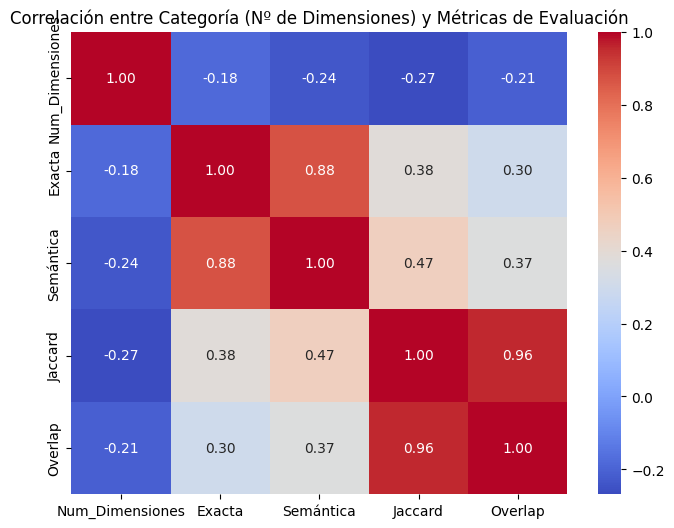

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20588\971324359.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


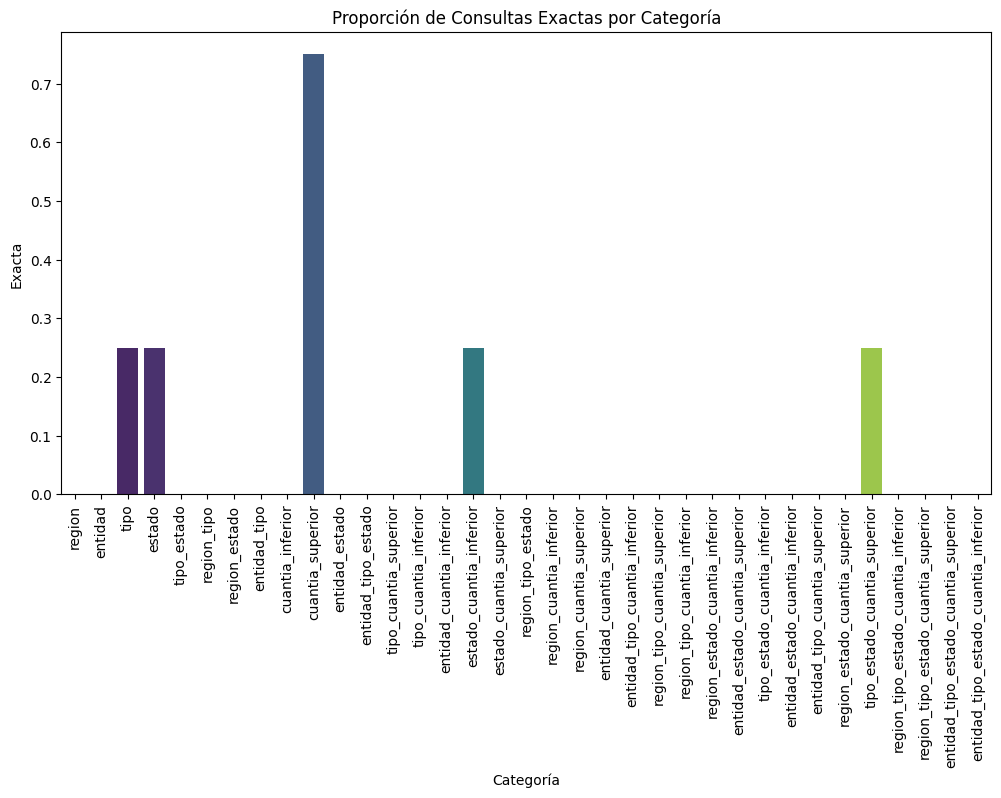

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20588\971324359.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


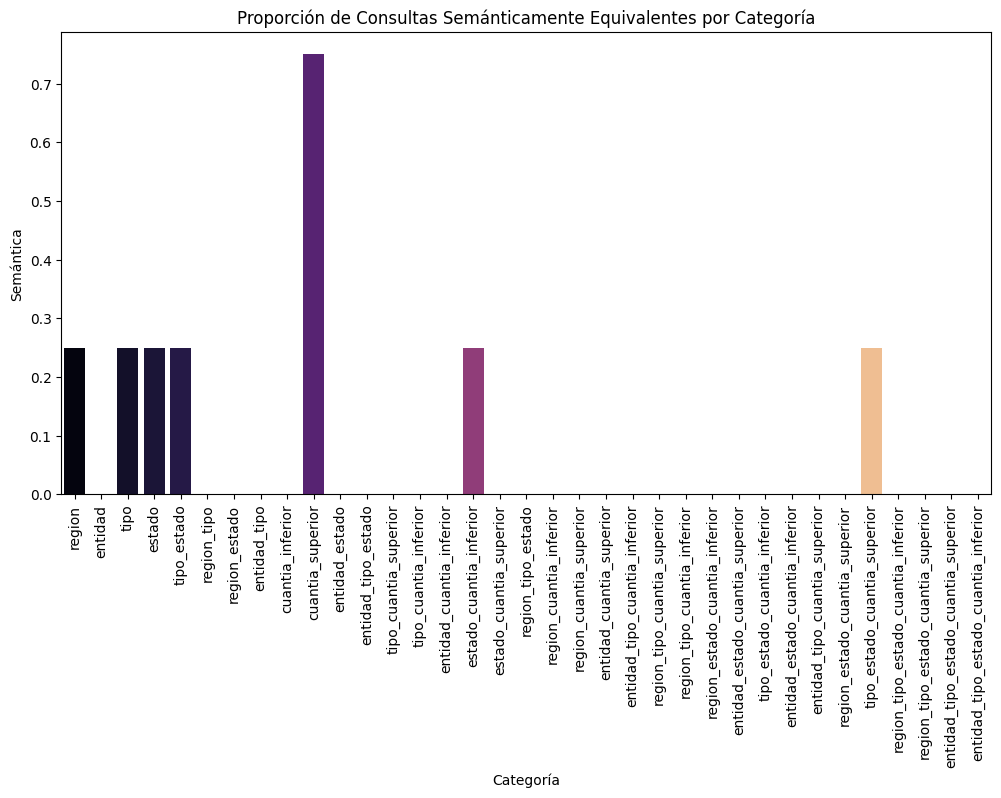

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20588\971324359.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


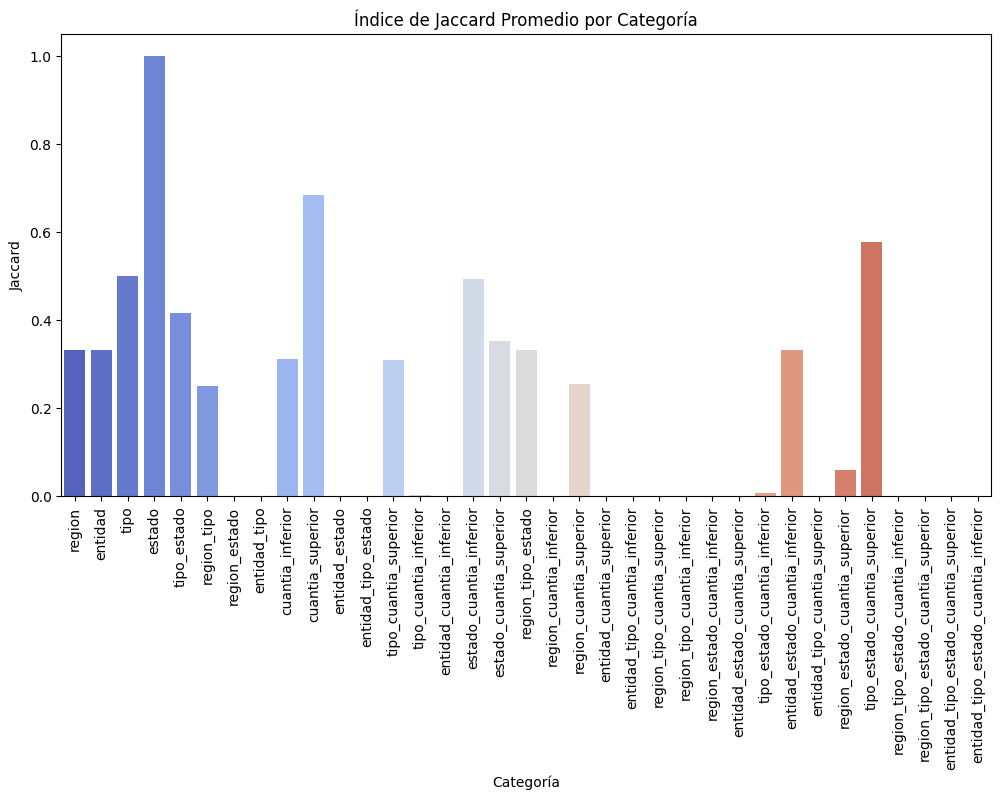

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_20588\971324359.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


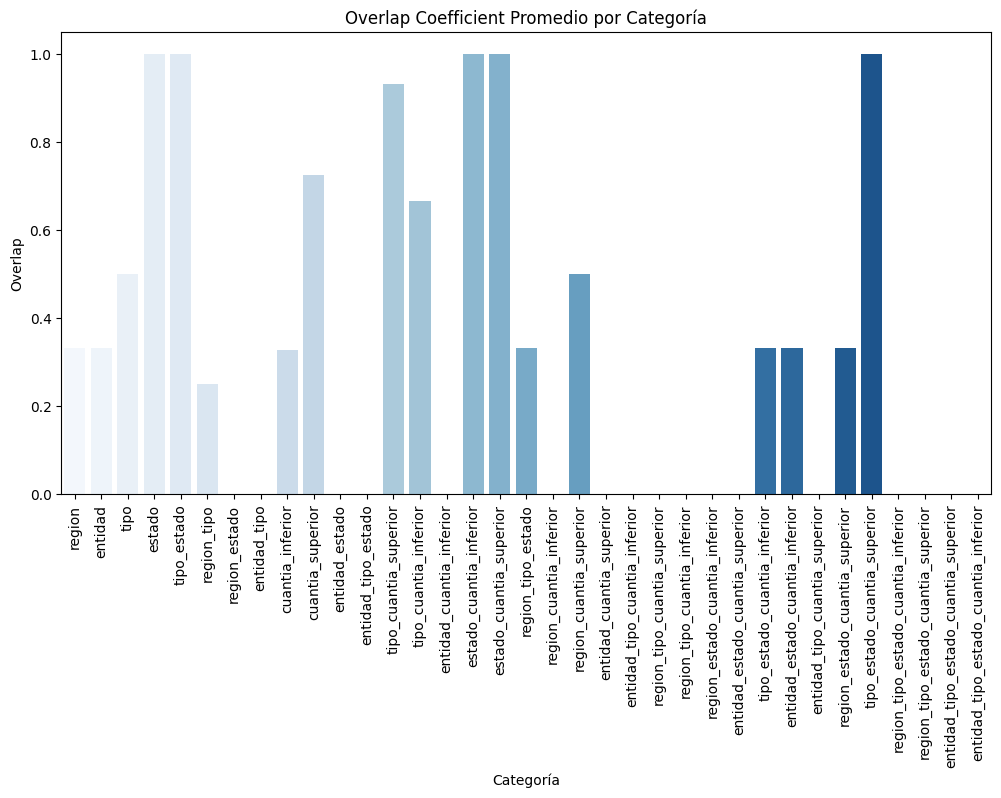

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Verificar las categorías únicas en el dataset
categorias_unicas = df_final_resultados["Categoría"].unique()

# Contar el número de dimensiones en cada categoría
def contar_dimensiones(categoria):
    return categoria.count("_") + 1  # Contamos los guiones bajos y sumamos 1

df_final_resultados["Num_Dimensiones"] = df_final_resultados["Categoría"].apply(contar_dimensiones)

# Calcular las correlaciones entre el número de dimensiones y las métricas
correlaciones = df_final_resultados[["Num_Dimensiones", "Exacta", "Semántica", "Jaccard", "Overlap"]].corr(method="spearman")

# Mostrar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlaciones, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre Categoría (Nº de Dimensiones) y Métricas de Evaluación")
plt.show()

# ---- AGRUPACIÓN Y ORDENACIÓN DE CATEGORÍAS POR Num_Dimensiones ---- #
# 1. Agrupamos por Categoría para calcular la media de las métricas
# 2. Recuperamos un único valor de Num_Dimensiones para cada Categoría
# 3. Ordenamos el dataframe resultante según Num_Dimensiones

categoria_metricas = (
    df_final_resultados
    .groupby("Categoría")
    .agg({
        "Exacta": "mean",
        "Semántica": "mean",
        "Jaccard": "mean",
        "Overlap": "mean",
        "Num_Dimensiones": "first"  # o 'min'/'max', todas deben ser iguales para la misma categoría
    })
    .reset_index()
    .sort_values("Num_Dimensiones")  # Orden ascendente por Num_Dimensiones
)

# Creamos una lista que represente el orden de categorías para los gráficos
orden_categorias = categoria_metricas["Categoría"].tolist()

# ---- VISUALIZACIÓN ---- #
plt.figure(figsize=(12, 6))
sns.barplot(
    data=categoria_metricas,
    x="Categoría",
    y="Exacta",
    palette="viridis",
    order=orden_categorias  # aquí forzamos el orden
)
plt.xticks(rotation=90)
plt.title("Proporción de coincidencias exactas por Categoría")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=categoria_metricas,
    x="Categoría",
    y="Semántica",
    palette="magma",
    order=orden_categorias
)
plt.xticks(rotation=90)
plt.title("Proporción de consultas semánticamente equivalentes por Categoría")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=categoria_metricas,
    x="Categoría",
    y="Jaccard",
    palette="coolwarm",
    order=orden_categorias
)
plt.xticks(rotation=90)
plt.title("Índice de Jaccard promedio por Categoría")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=categoria_metricas,
    x="Categoría",
    y="Overlap",
    palette="Blues",
    order=orden_categorias
)
plt.xticks(rotation=90)
plt.title("Overlap Coefficient promedio por Categoría")
plt.show()
